In [1]:
# Import the required packages.
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import numpy as np
import random
import transformers

# Create a data loader
# Real data label is 0, generated image label is 1

train_dir = '/kaggle/input/apoai-2-dataset'

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for label, sub_dir in enumerate(os.listdir(root_dir)):
            print(label)  #Just print out all the labels and you can see what this code means.
            full_dir = os.path.join(root_dir, sub_dir)
            for img_name in os.listdir(full_dir):
                img_path = os.path.join(full_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
if False:
    stds = [[], [], []]
    means = [[], [], []]
    for i in range(len(train_dataset)):
        img = np.asarray(train_dataset[i][0])
        for j in range(3):
            stds[j].append(img[:, :, j].std())
            means[j].append(img[:, :, j].mean())
    for i in range(3):
        stds[i] = np.mean(stds[i]) / 255
        means[i] = np.mean(means[i]) / 255

In [8]:
# лучше без препроцессинга, потому что его нет на инференсе
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    # transforms.Normalize(means, stds) # - in case you want to use mean and std on your data
    # transforms.Normalize((0.5), (0.5)) # - standart normalization
])

train_dataset = CustomDataset(train_dir, transform=transform)
train_dataset, eval_dataset = random_split(train_dataset, lengths=[0.95,0.05])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)

0
1


In [5]:
#  Training function
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

def train_model(model, train_loader, eval_loader, criterion, optimizer, scheduler, device, num_epochs=10, verbose=False):
    max_accuracy = 0 #  Print the highest accuracy.
    best_model = -1
    lrs = []
    lossi = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        stream = tqdm(train_loader, desc='Training') if verbose else train_loader
        for inputs, labels in stream:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            scheduler.step()
            lossi.append(loss.item())
            lrs.append(optimizer.param_groups[0]["lr"])
        epoch_loss = running_loss / len(train_loader.dataset) 
        eval_accuracy = eval_model(model, eval_loader, device)
        if verbose and epoch % verbose == 0:
            train_accuracy = eval_model(model, train_loader, device) 
            log_message = f'Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.4f}, Eval Accuracy: {eval_accuracy:.4f}'
            print(log_message)
            sns.scatterplot(lrs)
            plt.show()
            sns.scatterplot(lossi)
            plt.show()
        if eval_accuracy > max_accuracy:
            max_accuracy = eval_accuracy
            best_model = model
    return best_model, max_accuracy

#  Evaluation function.
def eval_model(model, data_loader, device):
    model.eval()
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(inputs)
            preds = outputs >= 0.5
            corrects += torch.sum(preds == labels).item()
            total += labels.size(0)
    accuracy = corrects / total
    return accuracy


In [6]:
  class MyModel(nn.Module):
    def __init__(self, conf):
        super(MyModel, self).__init__()
        #net params
        self.k1 = conf['k1']
        self.k2 = conf['k2']
        self.k_max = conf['k_max']
        self.c2 = conf['c2']
        self.c1 = conf['c1']
        self.i = conf['i']
        self.pad1 = conf['pad1']
        self.pad2 = conf['pad2']
        
        #convs
        self.conv1 = nn.Conv2d(3, self.c1, self.k1, padding=self.pad1)
        self.conv2 = nn.Conv2d(self.c1, self.c2, self.k2, padding=self.pad2)

        #maxpool
        self.pool = nn.MaxPool2d(self.k_max, self.k_max)

        #counting number of features after ravelling
        self.final_n = (((32 + 2 * self.pad1 - self.k1 + 1) // self.k_max) + 2 * self.pad2 - self.k2 + 1) // self.k_max

        #linear layers
        self.fc1 = nn.Linear(self.c2 * self.final_n * self.final_n, 2 ** self.i)
        self.fc2 = nn.Linear(2 ** self.i, 1)

        #activations
        self.leaky_relu = nn.LeakyReLU()
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

        #dropout
        self.dp  = nn.Dropout(p=conf['dp_p'])

    def forward(self, x):
        x = self.pool(self.elu(self.conv1(x)))
        x = self.pool(self.elu(self.conv2(x)))
        x = x.flatten(start_dim=1)
        x = self.leaky_relu(self.dp(self.fc1(x)))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [9]:
# best params from optuna:
# batch_size: 64
# k1: 2
# k2: 3
# c1: 30
# c2: 54
# k_max: 5
# i: 9
# dp_p: 0.2072487800231326
# pad1: 3
# pad2: 5
# lr: 0.003933660390418468
# warm_epochs: 3
# scheduler: cosine

model_conf = {
    'k1' : 2,
    'k2' : 3,
    'c1' : 30,
    'c2' : 54,
    'k_max' : 5,
    'i' : 9,
    'dp_p' : 0.2072487800231326,
    'pad1' : 3,
    'pad2' : 5
}

In [10]:
# Set all hyperparameters according to best set

#  Set up device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

#  Create model, loss function, and optimizer.
model = MyModel(model_conf).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.003933660390418468)
epochs = 20

num_total_steps = len(train_loader) * epochs
num_warmup_steps = len(train_loader) * 3

scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=num_warmup_steps, 
    num_training_steps=num_total_steps
)

Using device: cuda


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch 1/20, Train Accuracy: 0.6167, Eval Accuracy: 0.5880


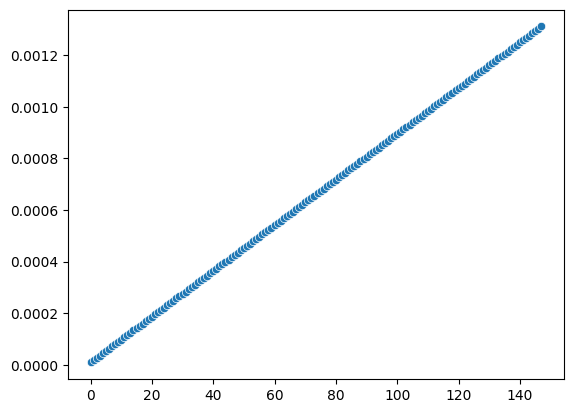

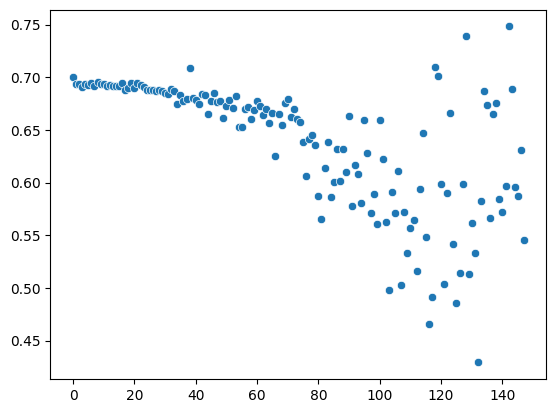

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch 4/20, Train Accuracy: 0.7607, Eval Accuracy: 0.7560


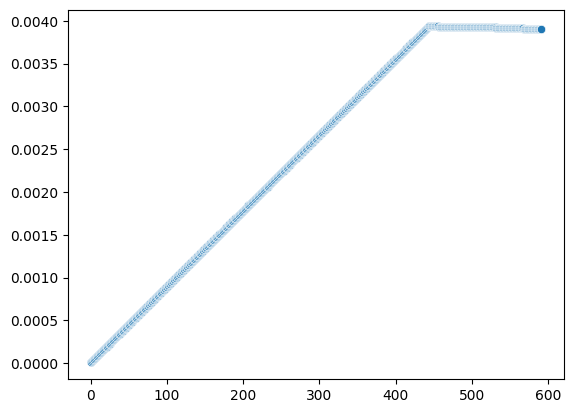

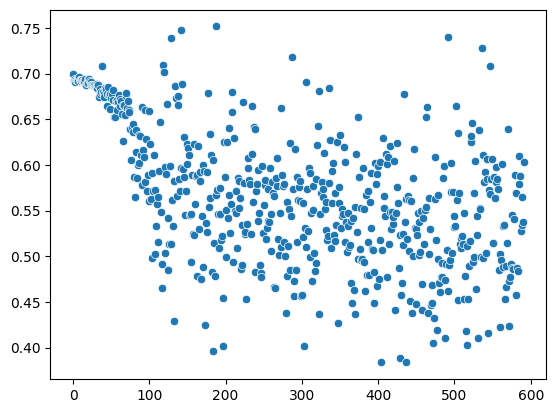

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch 7/20, Train Accuracy: 0.7881, Eval Accuracy: 0.7680


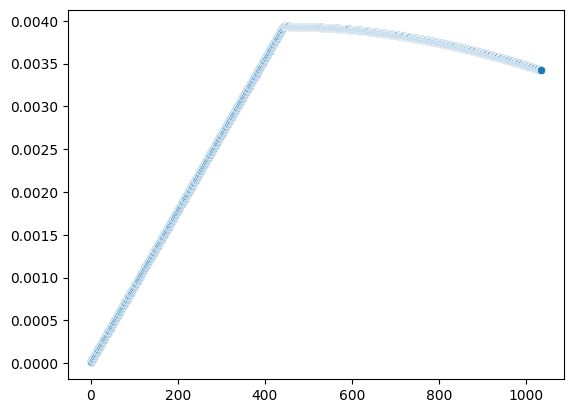

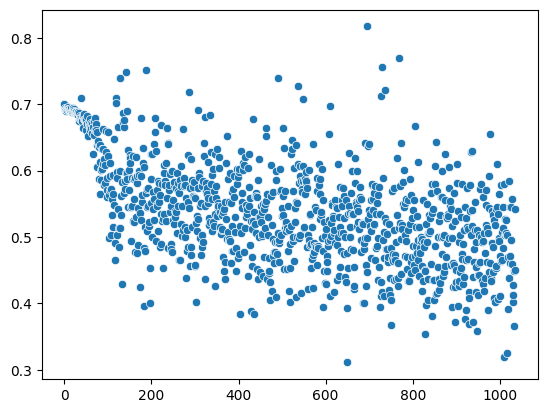

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch 10/20, Train Accuracy: 0.8126, Eval Accuracy: 0.7500


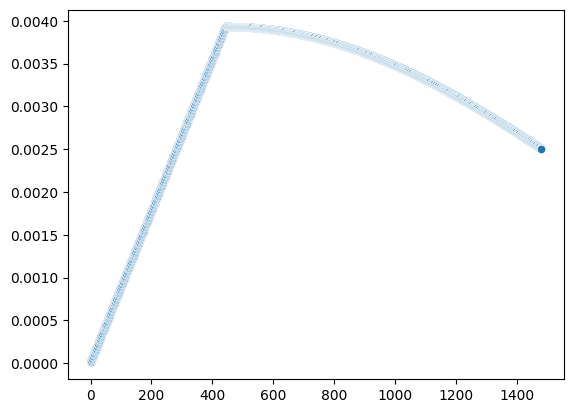

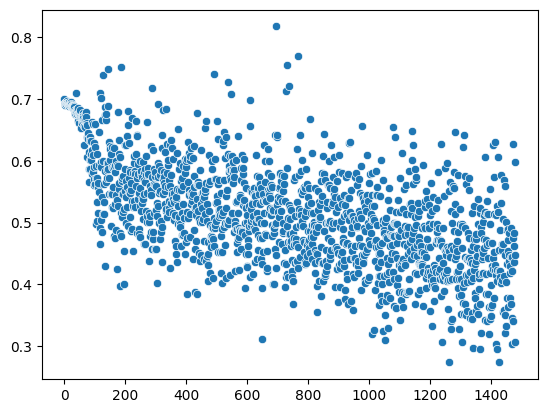

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch 13/20, Train Accuracy: 0.8680, Eval Accuracy: 0.7580


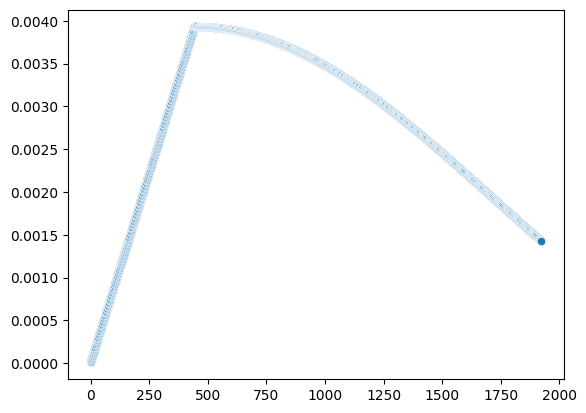

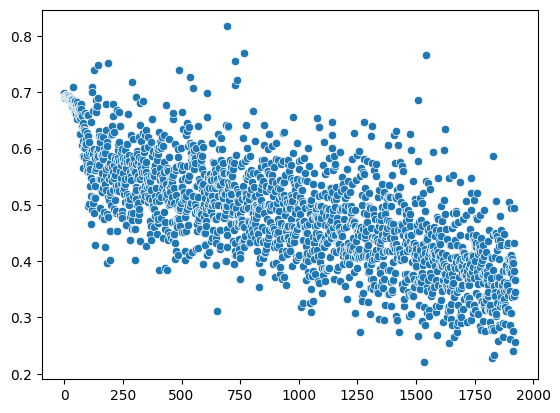

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch 16/20, Train Accuracy: 0.9067, Eval Accuracy: 0.7720


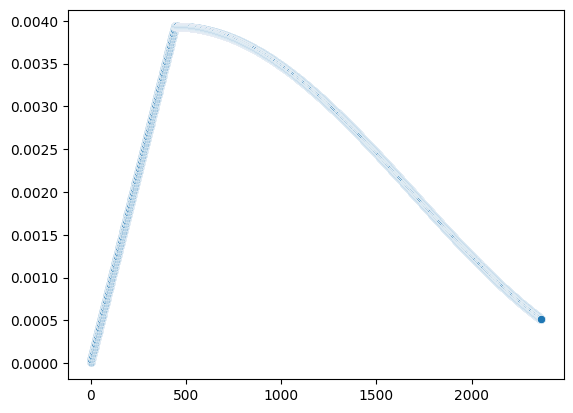

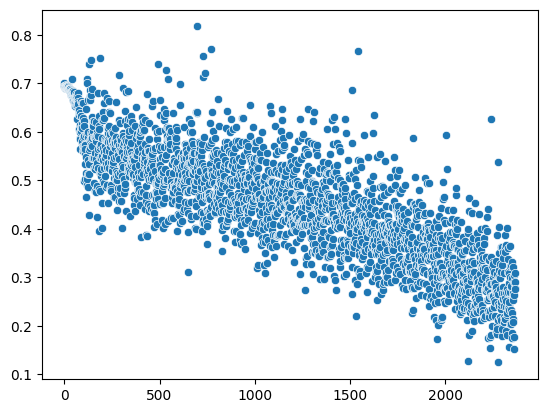

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch 19/20, Train Accuracy: 0.9212, Eval Accuracy: 0.7640


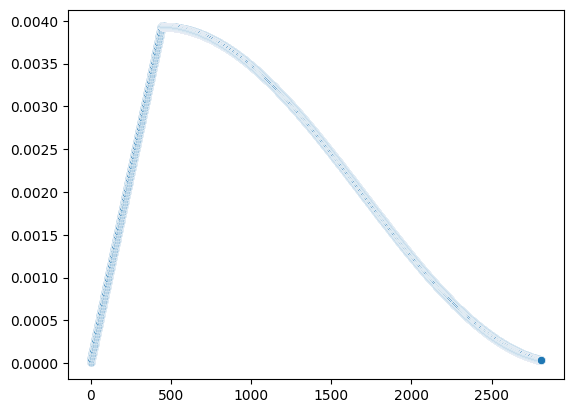

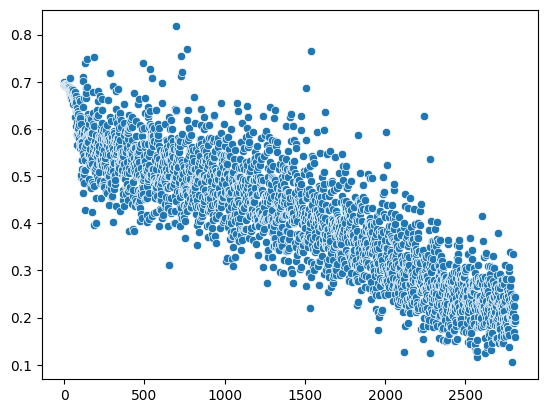

Training:   0%|          | 0/148 [00:00<?, ?it/s]

In [11]:
best_model, max_acc = train_model(model, train_loader, eval_loader, criterion, optimizer, scheduler, device, num_epochs=epochs, verbose=3)

In [ ]:
# setting everything for optuna 

import optuna
import random

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.enabled=False
    torch.backends.cudnn.deterministic=True


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_dir, transform=transform)
train_dataset, eval_dataset = random_split(train_dataset, lengths=[0.85,0.15])

def objective(trial):

    try:

        set_seed(56)
    
        BATCH_SIZE = trial.suggest_categorical('batch_size', [64,128,256])
    
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
        eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
        model_conf = {
            'k1' : trial.suggest_int('k1', 2,6),
            'k2' : trial.suggest_int('k2', 2,6),
            'c1' : trial.suggest_int('c1', 4,33),
            'c2' : trial.suggest_int('c2', 4,65),
            'k_max' : trial.suggest_int('k_max', 2,5),
            'i' : trial.suggest_int('i', 5,11),
            'dp_p' : trial.suggest_float('dp_p', 5e-2, 4e-1),
            'pad1' : trial.suggest_int('pad1', 1,5),
            'pad2' : trial.suggest_int('pad2', 1,5)
        }
    
        LR = trial.suggest_float('lr', 1e-5, 8e-3)
        WARM_EPOCHS = trial.suggest_int('warm_epochs', 1,10)
        SCHEDULER = trial.suggest_categorical('scheduler', ['cosine', 'linear'])
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        model = MyModel(model_conf).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.AdamW(model.parameters(), lr=LR)
        epochs = 10
        
        num_total_steps = len(train_loader) * epochs
        num_warmup_steps = len(train_loader) * WARM_EPOCHS
    
        if SCHEDULER == 'linear':
        
            scheduler = transformers.get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=num_warmup_steps, 
                num_training_steps=num_total_steps
            )
            
        else:
            
            scheduler = transformers.get_cosine_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=num_warmup_steps, 
                num_training_steps=num_total_steps
            )
    
        best_model, max_acc = train_model(model, train_loader, eval_loader, criterion, optimizer, scheduler, device, num_epochs=epochs, verbose=False)
    
        return max_acc
    except:
        return -1

In [ ]:
#starting optimizing

study = optuna.create_study(
    study_name="tuning_cnn",
    direction="maximize",
    load_if_exists=True,
)
study.optimize(objective, n_trials=100, timeout=30_000)

In [ ]:
#saving results
import pickle

with open('results.pickle', 'wb') as f:
    pickle.dump(study, f)

In [ ]:
# get best params
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [17]:
# commit best model code
model_code = """  
import torch
import torch.nn as nn
import torch.optim as optim
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        conf = {
            'k1' : 2,
            'k2' : 3,
            'c1' : 30,
            'c2' : 54,
            'k_max' : 5,
            'i' : 9,
            'dp_p' : 0.2072487800231326,
            'pad1' : 3,
            'pad2' : 5
        }
        self.k1 = conf['k1']
        self.k2 = conf['k2']
        self.k_max = conf['k_max']
        self.c2 = conf['c2']
        self.c1 = conf['c1']
        self.i = conf['i']
        self.pad1 = conf['pad1']
        self.pad2 = conf['pad2']
        self.conv1 = nn.Conv2d(3, self.c1, self.k1, padding=self.pad1)
        self.pool = nn.MaxPool2d(self.k_max, self.k_max)
        self.conv2 = nn.Conv2d(self.c1, self.c2, self.k2, padding=self.pad2)
        self.final_n = (((32 + 2 * self.pad1 - self.k1 + 1) // self.k_max) + 2 * self.pad2 - self.k2 + 1) // self.k_max
        self.fc1 = nn.Linear(self.c2 * self.final_n * self.final_n, 2 ** self.i)
        self.fc2 = nn.Linear(2 ** self.i, 1)
        self.leaky_relu = nn.LeakyReLU()
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.pool(self.elu(self.conv1(x)))
        x = self.pool(self.elu(self.conv2(x)))
        x = x.flatten(start_dim=1)
        x = self.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
"""


# Write the model code into a file.
with open('submission_model.py', 'w') as f:
    f.write(model_code)
print("submission_model.py file is generated.")
torch.save(best_model.state_dict(), 'submission_dic.pth')

submission_model.py file is generated.


In [18]:
import zipfile
import os

# Define the files to be packaged and the compressed file name.
files_to_zip = ['submission_model.py', 'submission_dic.pth']
zip_filename = 'submission_optuna_fixed.zip'

# Create a zip file
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in files_to_zip:
        # 将Add files to the zip file.
        zipf.write(file, os.path.basename(file))

print(f'{zip_filename} is created successfully!')

submission_optuna_fixed.zip is created successfully!
